In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.model_selection import train_test_split

%matplotlib inline

In [72]:
cur = ('INR', 'Nifty 50')
transf = None
shuffle = False

forex = pd.read_csv('prep_forex.csv', header=[0,1], index_col=0)
index = pd.read_csv('prep_index.csv', header=[0,1,2], index_col=0)

forex_pairs = list(set([x[1] for x in forex.columns if x[0] == 'Close' and x[1] == cur]))
index_pairs = list(set([(x[1], x[2]) for x in index.columns if x[0] == 'Close' and x[1] == cur[0]]))


metric = 'Close'
metrics = ['Open', 'Close', 'Low', 'High']
target = [metric]
features = ['Intraday_HL', 'Intraday_OC', 'Prev_close_open'] + [y+x for x in ['', '_Ret', '_Ret_MA_3', '_Ret_MA_15', '_Ret_MA_45', '_MTD', '_YTD'] for y in metrics]# if (x+y) not in target]

index_pairs

[('INR', 'Nifty 50'), ('INR', 'BSE Sensex')]

In [73]:
def split_scale(X, y, scaler, shuffle=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=shuffle, test_size=0.2)
    if(scaler is None):
        return(X_train, X_test, y_train, y_test)
    else:
        scaler_X = scaler()
        if(scaler == scalers[-1]):
            scaler_X = scaler(np.log1p)
        scaler_X = scaler_X.fit(X_train)
        X_train = scaler_X.transform(X_train)
        X_test = scaler_X.transform(X_test)
        scaler_y = scaler()
        if(scaler == scalers[-1]):
            scaler_y = scaler(np.log1p)
        scaler_y = scaler_y.fit(y_train)
        y_train = scaler_y.transform(y_train)
        y_test = scaler_y.transform(y_test)
        return(X_train, X_test, y_train, y_test)

In [74]:
# forex_cols = [x for x in forex.columns if x[1] == cur]
# X = forex[[col for col in forex_cols if col[0] in features + ['Time features']]][:-1]
# y = forex[[col for col in forex_cols if col[0] in target]].shift(-1)[:-1]

index_cols = [x for x in index.columns if x[1] == cur[0] and x[2] == cur[1]]
X = index[[col for col in index_cols if col[0] in features + ['Time features']]][:-1]
y = index[[col for col in index_cols if col[0] in target]].shift(-1)[:-1]

X_train, X_test, y_train, y_test = split_scale(X, y, transf, shuffle)

In [75]:
y_train = y_train.reset_index()
y_train.columns = ['ds', 'y']

In [76]:
m = Prophet()
# m.add_seasonality(name='yearly', period='20', fourier_order=5)
m.fit(y_train)
future = m.make_future_dataframe(len(y_test))
# future['cap'] = 8
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [77]:
res = pd.concat([y.reset_index(drop=True), forecast['yhat']], axis=1, ignore_index=True)
res.index = y.index
res.columns = ['y_true', 'y_pred']
res.head()

,y_true,y_pred
Date,,
2010-01-01,5232.20,4987.455371
2010-01-04,5277.90,4987.130999
2010-01-05,5281.80,4991.941910
2010-01-06,5263.10,4995.034805
2010-01-07,5244.75,4998.828841


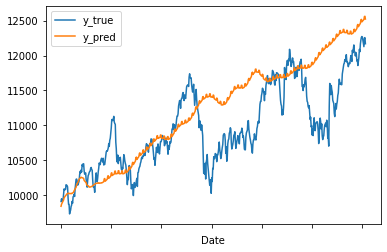

In [78]:
res.iloc[2000:,:].plot()